# Bayesian Networks for Estimating Attack Vector

## Intro & motivating example

Humans are notoriously bad at reasoning about probabilities: more often than not, we rely on cognitive shortcuts (heuristics and biases) instead of actually calculating the liklihood of events. This can be a good thing; just think how paralyzed we would be if we stopped to calculate the probability of rain every time we heard raindrops on our window, rather than just grabbing an umbrella! Even computers can start to run into tractability problems when working with probability distributions involving even a few dozen variables. In this tutorial, we will introduce a tool, called Bayesian networks, for automatically and efficiently reasoning about probabilities. These networks will allow us to ask questions like "given this new evidence, what is the probability of some hidden variable being true" or "what is the most likely explanation for some set of observations?". These questions might remind you of our lectures on Hidden Markov Models (HMMs); it turns out that Bayesian networks can be used to represent Markov processes, but they are much more expressive and can be used to model much more complicated scenarios.

To make this discussion more concrete, it's helpful to have a motivating example. You are a security engineer in the employ of the Generic Galactic Empire aboard a controversial new ~~moon~~ space station. You are aware of several security vulnerabilities in the space station's software subsystems, but you have no way to detect whether those vulnerabilities are being exploited except by running diagnostics on various workstations throughout the station. Since you'd like to be able to detect attacks based on the probability that a vulnerability is being exploited, you'd like an easy way to relate your observations of workstations to the probability of a cyberattack taking place. After a brief review of probability fundamentals, we'll discuss how Bayesian networks can be used to model this situation and make inferences automatically.

### References
The discussion in this tutorial draws heavily from the following sources:
- Russell & Norvig, AIMA, Chapter 13 & 14
- [R. Dechter, "Bucket Elimination: A Unifying Framework for Probabilistic Inference"](https://webdocs.cs.ualberta.ca/~rgreiner/C-366/RG-2002-SLIDES/BucketElim.pdf) 

Chapter 13 of AIMA provides an overview of probability fundamentals, while chapter 14 discusses Bayesian networks in more depth. Dechter's article describes efficient algorithms for making inference based on Bayesian networks.

## Probability Review

This section will provide a quick review of relevant probability concepts. For a more thorough review, see Russel & Norvig AIMA, Chapter 13.

Given a set of $n$ discrete random variables, we can fully represent the probabilities and relationships between all $n$ variables using a table called the **joint distribution**. This table has a dimension for every variable and a row for each possible assignment to that variable; a joint distribution for 2 binary variables, $A$ and $B$, would have a row for each value of $A$ and a column for each value of $B$. Each entry in the joint distribution contains the probability that the corresponding assignment to each of the variables will be observed; in the $2\times2$ case, the $(0, 0)$ entry would contain the probability that $A=0$ and $B=0$.

Formally, the joint distribution allows us to lookup probabilities $P(A\land B \land C \land ...)$ just be reading the value out of the joint distribution table. They also allow us to find the so-called *marginal probability* of some variable $P(A)$, which is the probability that $A$ takes on some value regardless of the value of all other variables. In the binary case, $P(A) = P(A\land B) + P(A \land \text{not }B}$; in the general case, we can calculate the marginal probability by summing over all possible values of the variables we don't care about, like so: $$P(A) = \sum_{\text{all possible assignments to }B,C,\ldots} P(A \land B \land C \land \ldots$$

Often, we are interested in the case when we have observed some variable assignments (which we call the evidence variables $e$), and we are interested in the probability of some other variables ($X$) given those observations. This probability $P(X | e)$ is called the **conditional** or **posterior probability**, and it can be calculated using the product rule, $P(A\land e) = P(X|e) P(e)$, which we can rearrange to find 

$$P(X | e) = P(X\land e)/P(e) = \alpha P(X \land e)$$

where $\alpha$ is a normalization factor calculated so that $P(X | e) + P(\text{not }X | e) = 1$. Note that $P(X \land e)$ is simply a marginal probability, so we can compute it from the joint distribution as $$P(X\land e) = \sum_{\text{all possible assignments to }y\text{ not in}x, e}P(X \land e \land y)$$

    - Conditional/posterior probabilities, product rule P(A ^ B) = P(A | B)P(B), and conditioning (marginalization but with conditional probs).
    - Derive P(X|e) = P(X^e)/P(e) = aP(X^e) = a \sum_y P(X, e, y) (normalization to get a so that P(X|e)+P(!X|e)=1
    - Remark: this would allow us to answer whatever queries we want to ask just by looking in the joint distribution table. BUT that table has size O(2^n) and requires O(2^n) to process by summing over it.
- Reasoning using conditional distributions (13.4)
    - Lots of redundant information in full joint distribution (like how your toothache affects the weather, ignoring causality)
    - Independence! Conditional independence (based on causality)!
    - Allows factoring the joint distribution into multiple smaller conditional distributions, saving on size. 2^n+2^m << 2^{n+m}    

## Bayesian Networks

Exploiting conditional independence can allow us to reason much more efficiently about joint probabilities, but it would be really nice if we could automate the inference process by encoding conditional probabilities in a convenient data structure. Since dependence relates each variable to a set of "parent" variables, a natural structure is a directed graph, where
- Each node corresponds to an uncertain variable (in this tutorial, we'll restrict ourselves to discrete random variables),
- If variable $B$ is dependent on $A$, then we draw a directed edge from node `A` to node `B` in the graph, and
- Each node $X$ is labelled with its conditional probability distribution $P(X\ |\ \text{Parents}(X))$, which takes the form of a table with a row for each combination of assignments to the parent variables of $X$, specifying the probabilities that $X$ takes on each of its values conditioned on those parent variable assignments.

Since we don't want any variable to depend (directly or indirectly) on itself, this graph must not have any directed cycles (making it a *directed acyclic graph*. An example graph is shown in the figure below. Given this structure, we can see that it directly encodes both independence and conditional independence: sibling nodes (i.e. nodes sharing a parent) are conditionally independent, while nodes in disconnected graphs are independent.

We call this data structure a Bayesian network (or sometimes a *belief network* or *causal network*). These networks can represent any full joint distribution, but depending on the degree to which causal relationships allow us to factor the joint distribution into smaller conditional distributions, Bayesian networks can encode this information much more compactly. In the next example, we'll give a simple example of a Bayesian network and show how we can make inference based on these networks.

### A simple example

Before moving on to the more complicated case of our original motivating problem, we'll use the simpler scenario from Fig. 14.2 in Russel & Norvig to illustrate the key features of Bayesian networks. In this scenario, you've just installed a new alarm in your house, and since you don't want Google spying on your home, you've chosen not to connect the alarm to the internet. Instead, you've asked your neighbors, John and Mary, to listen for the alarm and call you if they hear it going off. Complicating matters, the alarm will go off if a burglary occurs, but it is a little too sensitive and will also go off if an earthquake occurs. In addition, John will will sometimes confuse a telephone ringing for the alarm and call then as well, and because Mary likes listening to loud music, she will sometimes miss the alarm altogether.

In this scenario, we essentially have five uncertain boolean variables:
+ `B`: whether a burglary has occurred,
+ `E`: whether an earthquake has occurred,
+ `A`: whether the alarm has gone off,
+ `J`: whether John calls you, and
+ `M`: whether Mary calls you.

Note that only `J` and `M` are observable. If we were to encode the full joint probability distribution, we'd need to store a table of size $O(2^n) = O(32)$. This is not too large in thi scase, but if you have even 30 variables then the joint distribution table would require $O(4$ GB$)$ of storage, and adding a 31st variable would require another 4 GB! We are clearly on the wrong side of this exponential when it comes to the joint distribution.

To make the problem more tractable, we can exploit the causal relationships between these variables, allowing us to store a handful of smaller conditional distributions rather than a monolithic joint distribution. The causal structure of this problem leads to the Bayesian network shown in the image below (reprinted from Russell & Norvig):

<img src="files/figs/alarm-problem-structure.png">

Since `J` and `M` only depend on `A`, we don't need to explicitly store the effect of an earthquake on the probability of John calling. Instead of a 32-entry joint distribution, we only need to store 20 values in 5 smaller conditional distributions. Only 10 entries are shown here because for boolean variables the probability of a false value is fixed at 1-(the probability of a true value). For scenarios with even more variables, these savings would be even more dramatic.

It's important to note that the Bayesian network representation is not unique: you can order the variables in any way you want and back out the conditional probability tables from the joint distribution. In this case, we have ordered the nodes from causes to effects (causes at the top, flowing down to effects at the bottom of the network). This is a good heuristic for constructing concise Bayesian networks.

We've written classes in `bayes_net.py` implementing the basic functionality of Bayesian networks for you, allowing you to represent these networks programmatically. You should go check out the source code to get an idea of what features are available, and a basic example of constructing a network for this example scenario is given below. To properly load the drawing function, **you must run this cell twice**.

Have 5 nodes and 4 edges


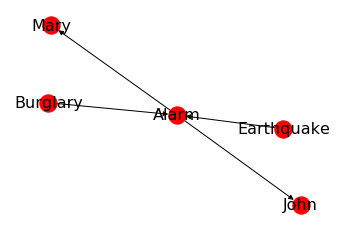

In [4]:
## Example code for constructing the simple burglary example from AIMA (Fig. 14.2)
from bayes_net import BayesNet, BayesNode
import numpy as np

# First, instantiate the two nodes that have no parents in the network.
# The domain of these variables is just {True, False} here, but we support arbitrary discrete domains
burglary_node = BayesNode('Burglary')
burglary_node.set_marginal_distribution({True: 0.001, False: 0.999})
earthquake_node = BayesNode('Earthquake')
earthquake_node.set_marginal_distribution({True: 0.002, False: 0.998})

# Now we can instantiate nodes with probabilities conditioned on their parents
# We have to build the conditional distribution table one entry at a time, for each combination
# of parent variables
alarm_node = BayesNode('Alarm')
alarm_node.add_entry([(burglary_node, True), (earthquake_node, True)], {True: 0.95, False: 0.05})
alarm_node.add_entry([(burglary_node, True), (earthquake_node, False)], {True: 0.94, False: 0.06})
alarm_node.add_entry([(burglary_node, False), (earthquake_node, True)], {True: 0.29, False: 0.71})
alarm_node.add_entry([(burglary_node, False), (earthquake_node, False)], {True: 0.001, False: 0.999})

john_node = BayesNode('John')
john_node.add_entry([(alarm_node, True)], {True: 0.9, False: 0.1})
john_node.add_entry([(alarm_node, False)], {True: 0.05, False: 0.95})

mary_node = BayesNode('Mary')
mary_node.add_entry([(alarm_node, True)], {True: 0.7, False: 0.3})
mary_node.add_entry([(alarm_node, False)], {True: 0.01, False: 0.99})

# Now we can create a BayesNet object to store all the nodes.
alarm_net = BayesNet([burglary_node, earthquake_node, alarm_node, john_node, mary_node])

# As a sanity check, we can visualize the network to make sure it matches our model above.
# This visualization is auto-generated, so it will be a bit messy, but we can still see
# the overall structure of the network.
alarm_net.draw_net()

We can use similar code to construct a more complicated network based on our original motivating example (cyberattack estimation).

In [12]:
### Insert code for star wars network once we have data!

### Inference on Bayesian Networks

Now that we've constructed a bayesian network, what can we do with it? In short, everything you can do with the full joint distribution! In the next few sections, we'll discuss algorithms for computing:
- The joint probability distribution e.g. P(a, b, !c, d, !e)
- The posterior probability given evidence e.g. P(X | e) = aP(X, e)
- The maximum liklihood explanation of a set of evidence, which is the assignments to X with the highest probability given e. This is often called the maximum a posteriori estimate, or MAP estimate.

#### Calculating Joint Probabilities

In general, the joint probability for variable assignments $x_1,\ldots, x_n$ is given by

$$P(x_1,\ldots, x_n) = \prod_{i=1}^n P(x_i\ |\ \text{Parents}(x_i))$$

where we can simply read $P(x_i\ |\ \text{Parents}(x_i)$ out of the conditional distribution attached to node `x_i`. In the context of our specific example, say we want to know the probability `B = True`, `E = False`, `A = True`, `J = True`, `M = True` (the probability that we got a call from John and Mary, the alarm has gone off, there has been a burglary, and there has been no earthquake). Using the general formula above, we get this joint probability as:

$$\begin{align*}
P(M, J, A, not E, B) &= P(M | A) \cdot P(J |A) \cdot P(A | not E, B) \cdot P(not E) \cdot P(B) \\
                     &= 0.7 \cdot 0.9 \cdot 0.94 \cdot 0.998 \cdot 0.001 \\
                     &= 0.00059
\end{align*}$$

This functionality is implemented in the provided `BayesNet` class, which we can query directly as shown below.

In [5]:
joint_prob = alarm_net.calc_joint([(mary_node, True), 
                                   (john_node, True),
                                   (alarm_node, True),
                                   (earthquake_node, False),
                                   (burglary_node, True)])
print('P(M, J, A, not E, B) = {}'.format(joint_prob))

P(M, J, A, not E, B) = 0.0005910156


#### Calculating Posterior Probabilities

With this ability to query the joint distribution, we can answer a broad range of other questions. For instance, if we want to know the posterior probability of some event $X$ after observing some evidence $e$, we can calculate

$$P(X|e) = \alpha P(X, e) = \alpha \sum_{y \notin \{X,e\}} P(X, e, y)$$

where $\alpha$ is a normalization constant set so that $P(X|e) + P(not X|e) = 1$. In our example, if we want to know the probability of a burglary having occured if we receive a call from John and Mary, we can calculate

$$\begin{align*}
P(B|J, M) = \alpha P(B, J, M) &= \alpha \sum_{a \in \{A, not A\}}\sum_{e \in \{E, notE\}} P(B, J, M, a, b, e)
\end{align*}$$

where $P(B, J, M, a, b, e)$ is a joint probability calculated as shown above. Substituting the equation for joint probabilities into this expression, we get 

$$\begin{align*}
P(B | J, M) = \alpha P(B, J, M) &= \alpha \sum_{a \in \{A, not A\}} \sum_{e \in \{E, notE\}} P(B, J, M, a, B, e) \\
                              &= \alpha \sum_{a \in \{A, not A\}}\sum_{e \in \{E, notE\}} P(M | a) \cdot P(J | a) \cdot P(a | e, B) \cdot P(e) \cdot P(B)
\end{align*}$$

This is a convenient feature, but without further optimization it is pretty inefficient: we need to multiply $n$ values for each of $2^n$ combinations of variable assignments, so this method has time complexity $O(n2^n)$, which again puts us on the losing side of an exponential term. We've implemented this brute-force algorithm (as described in AIMA 14.4.1) in the cell below. You can see how it performs on the simple network we've defined above; later, we'll benchmark the performance of this algorithm compared to more efficient algorithms when run on larger networks.

In [6]:
import itertools

def brute_force_query(X, e, net):
    """Returns the NON-NORMALIZED posterior probability P(X=x | e) using the Bayesian network `net`,
    using a brute force enumeration method with time complexity O(n2^n), where
    n is the number of variables in the network.
    
    Inputs:
        X: a list of tuples (name, value) specifying assignments to query variables
        e: a list of tuples (name, value) specifying assignments to evidence variables
            (we assume that e and X are disjoint)
        net: the bayesian network to calculate over
    Outputs:
        P: the probability that X=X given e
    """
    # initialize probability
    P = 0
    
    # convert all variable names to nodes in the net
    X_nodes = [net.get_node(var[0]) for var in X]
    e_nodes = [net.get_node(var[0]) for var in e]
    
    # extract all assignments to X and e variables
    X_assignments = [var[1] for var in X]
    e_assignments = [var[1] for var in e]
    # a list of (node, assignment) tuples for use in joint queries
    X_assignments = zip(X_nodes, X_assignments)
    X_assignments = [tuple(x) for x in X_assignments]
    e_assignments = zip(e_nodes, e_assignments)
    e_assignments = [tuple(x) for x in e_assignments]
    
    # get the list of variables not in X or e
    Y_nodes = [node for node in net.nodes if node not in X_nodes and node not in e_nodes]
    
    # now we sum the joint probability for all possible combinations of assignments to y
    y_assignments = list(itertools.product(*[list(var.domain) for var in Y_nodes]))
    
    for assignment in y_assignments:
        P += net.calc_joint(X_assignments + e_assignments + list(zip(Y_nodes, assignment)))
    
    return P

Using this method, we can determine the probability of a burglary having occured after having received a call from both John and Mary. Don't forget to normalize!

In [7]:
P_burglary = brute_force_query([('Burglary', True)], [('John', True), ('Mary', True)], alarm_net)
P_not_burglary = brute_force_query([('Burglary', False)], [('John', True), ('Mary', True)], alarm_net)

# normalize!
alpha = 1/(P_burglary + P_not_burglary)
P_burglary *= alpha
P_not_burglary *= alpha

print("P(B | j, m) = [{}, {}]".format(round(P_burglary, 3), round(P_not_burglary, 3)))

P(B | j, m) = [0.284, 0.716]


This works well, but $O(n2^n)$ is horribly slow! It works OK for the simple alarm network, which only has 5 variables ($5*2^5 = 160$), but if we add even just 5 more variables, we would require two orders of magniture more operations (since $10*2^10 = 10240$).

To get some efficiency improvements, we can exploit the structure inherent in this network to compute probabilities more easily. Recall that although we could theoretically order the nodes any way we want, we've chosen to structure the alarm network so that it flows from causes to effects. Because of this, we can order the variables so that causes precede effects, which means the equation for the conditional probability from above becomes:

$$\begin{align*}
P(B | J, M) &= \alpha \sum_{a \in \{A, not A\}}\sum_{e \in \{E, notE\}} P(B) \cdot P(e) \cdot P(a | e, B) \cdot P(M | a) \cdot P(J | a)
\end{align*}$$

We can reorder the summations and pull some of these terms outside of the sums, since $P(B)$ does not depend on either $a$ nor $e$, and $P(e)$ does not depend on the value of $a$. Thus, we get

$$\begin{align*}
P(B | J, M) &= \alpha P(B) \cdot \sum_{e \in \{E, notE\}} P(e) \cdot \sum_{a \in \{A, not A\}} P(a | e, B) \cdot P(M | a) \cdot P(J | a)
\end{align*}$$

This can noticeably reduce the number of expressions we need to evaluate, since we can enumerate the terms in this equation in a depth-first manner, as shown in the algorithm below (and described by Russel & Norvig in Figure 14.9 of AIMA). This algorithm boosts our time complexity from $O(n2^n)$ to $O(2^n)$, which is definitely noticeable but still unfortunately exponential. This is better, but still much slower than what we would like for inference on larger networks. In the next section, we'll discuss an algorithms for efficiently doing inference in polynomial time.

The depth-first enumeration query uses the following code:

In [10]:
# CITE: Russel & Norvig AIMA Ch 14, Section 4, Fig. 14.9
def simple_query(X, e, net):
    """Returns the NON-NORMALIZED posterior probability P(X=X | e) using the Bayesian network `net`,
    using an improved enumeration method with time complexity O(2^n), where n is
    the number of variables in the network, using analogue to depth-first search.
    
    Inputs:
        X: a list of tuples (name, value) specifying assignments to query variables
        e: a list of tuples (name, value) specifying assignments to evidence variables
            (we assume that e and X are disjoint)
        net: the bayesian net to calculate over
    Outputs:
        P: the probability that X=X given e
    """
    # augment e with known values of X
    augmented_e = X+e
    augmented_e = dict(augmented_e)
    # get names of all variables, in topographical order (from fewest parents to most parents)
    variables = [node.name for node in net.get_topographical_ordering()]
    # recursively compute conditional probability
    return enumerate_all(variables, augmented_e, net)

def enumerate_all(variables, e, net):
    """Computes one step in the depth-first iteration of the Bayesian network
    
    Inputs:
        variables: a list of the names of variables to be enumerated, ordered from parents to children
        e: a dict with keys name and values specifying assignments to variables of that name
        net: the bayesian net to calculate over
    Outputs:
        P: the marginal probability P(e=e)
    """
    # base case
    if len(variables) == 0:
        return 1.0
    
    # get first and rest of variables to enumerate
    y_first = variables[0]
    y_first_node = net.get_node(y_first)
    y_rest = variables[1:]
    
    # note that since we requrie variables to be ordered so that parents appear before children,
    # we know that all parents of y_first will already be in e (if y_first has parents)
    parent_assignments = []
    for parent in y_first_node.parents:
        assert (parent.name in e), "Variable names must be ordered so that parents appear before all their children"
        parent_assignments.append((parent, e[parent.name]))
    
    if y_first in e:
        # then y_first has an assignment specified in e
        y_first_val = e[y_first]
        return y_first_node.get_prob_value(y_first_val, parent_assignments) * enumerate_all(y_rest, e, net)
    else:
        # sum over all possible assignments of y_first
        sum = 0
        # we'll augment e with each possible assignment of y, so we need a copy
        e_aug = e.copy()
        for y_first_val in y_first_node.domain:
            e_aug[y_first] = y_first_val
            sum += y_first_node.get_prob_value(y_first_val, parent_assignments) * enumerate_all(y_rest, e_aug, net)
        return sum

Just like we could using the brute-force method, we can use this method to determine the probability of a burglary having occured after having received a call from both John and Mary. Again, don't forget to normalize!

In [11]:
P_burglary = simple_query([('Burglary', True)], [('John', True), ('Mary', True)], alarm_net)
P_not_burglary = simple_query([('Burglary', False)], [('John', True), ('Mary', True)], alarm_net)

# normalize!
alpha = 1/(P_burglary + P_not_burglary)
P_burglary *= alpha
P_not_burglary *= alpha

print("P(B | j, m) = [{}, {}]".format(round(P_burglary, 3), round(P_not_burglary, 3)))

P(B | j, m) = [0.284, 0.716]


## Bucket Elimination

In [1]:
# This is the main notebook to run.
# In this notebook, we go through the "attack-estimation" portion of the project.
# Some utility code, including base classes, lives in files outside this notebook.

In [2]:
# A bunch of imports
from bayes_net import BayesNet, BayesNode
import numpy as np

0.024000000000000004
Have 4 nodes and 3 edges


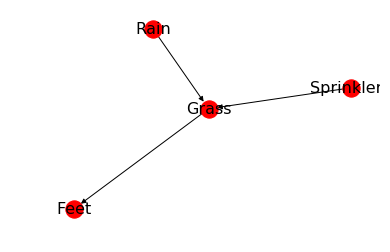

Rain
Sprinklers
Grass
Feet


In [3]:
# A demonstration for developers of how to create a BayesNet. In this example, I define the likelihood of getting
# wet feet as a function of wet grass, which is a function of raining and sprinkling.

# First, declare a bunch of nodes.
rain_node = BayesNode('Rain')
rain_node.set_marginal_distribution({True: 0.2, False: 0.8})
sprinklers_node = BayesNode('Sprinklers')
sprinklers_node.set_marginal_distribution({'on': 0.6, 'off': 0.4})
grass_node = BayesNode('Grass')
grass_node.add_entry([(rain_node, True), (sprinklers_node, 'on')], {'wet': 0.95, 'dry': 0.05})
grass_node.add_entry([(rain_node, True), (sprinklers_node, 'off')], {'wet': 0.6, 'dry': 0.4})
grass_node.add_entry([(rain_node, False), (sprinklers_node, 'on')], {'wet': 0.45, 'dry': 0.55})
grass_node.add_entry([(rain_node, False), (sprinklers_node, 'off')], {'wet': 0.1, 'dry': 0.90})
feet_node = BayesNode('Feet')
feet_node.add_entry([(grass_node, 'wet')], {'dry': 0.1, 'damp': 0.5, 'drenched': 0.4})
feet_node.add_entry([(grass_node, 'dry')], {'dry': 0.7, 'damp': 0.2, 'drenched': 0.1})

# Second, create a BayesNet object that just stores all the nodes.
net = BayesNet([rain_node, sprinklers_node, grass_node, feet_node])

# Third, do whatever you want with this data structure, like ask for the conditional distribution for a variable.
fetched_node = net.get_node('Feet')
assert fetched_node == feet_node  # Just a sanity check
# Calculate some joint probabilities
joint_prob = net.calc_joint([(rain_node, True), (sprinklers_node, 'off'), (feet_node, 'damp'), (grass_node, 'wet')])
print(joint_prob)

# Fourth, visualize it all. Right now, visualization is crude (weird layout) but should be correct (arrows the right way.)
net.draw_net()

# Fifth, show off a fancy new topographical ordering method I just wrote.
ordered_nodes = net.get_topographical_ordering()
for node in ordered_nodes:
    print(node.name)

Approximate Inference:

So far in this notebook, we've stuck with relatively small nets and simple distributions. That means that doing exact inference - calculating analytically exactly what some distribution will look like - is possible. For a lot of problems that we care about, though, exact inference isn't possible. There are lots of reasons this might happen: some distribution is wonky and therefore can't be reasoned about analytically, a net is so complex that doing all the math to marginalize out variables seems impossible, etc.

But we don't have to give up. In the following examples, we'll implement two sorts of approximate inference techniques: rejection sampling and Gibbs sampling.

In [4]:
def matches_evidence(node, value, evidence):
    for evidence_name, evidence_value in evidence:
        if node.name == evidence_name:
            if value == evidence_value:
                return True
            return False
    return True
    
# In this sampling method, we just generate random setups through sampling.
# If we satisfy the evidence, we save the state; if we don't we reject the sample and keep trying.
# After saving lots of states, the hope is that we have enough counts to estimate the frequencies of other variables
# conditioned on the evidence.
def rejection_sampling(X, e, net, num_samples=10000):
    # For each of the variables in X, store a count of how often each value in the domain appears.
    # Intialization to zero counts everywhere.
    var_to_val_to_count = {}
    for x in X:
        var_to_val_to_count[x] = {}
        for val in net.get_node(x).domain:
            var_to_val_to_count[x][val] = 0
    # Now, just generate tons of samples in the net, rejecting if it doesn't match the evidence.
    num_rejects = 0
    for sample_idx in range(num_samples):
        # Get a topographical ordering to start sampling.
        ordered_nodes = net.get_topographical_ordering()
        assignments = {}
        reject_sample = False
        for node in ordered_nodes:
            if node.marginal_distribution:
                sample = node.draw_sample()
                assignments[node] = sample
            else:
                parent_val_assignments = [(parent, assignments.get(parent)) for parent in node.parents]
                sample = node.draw_sample(parent_vals=parent_val_assignments)
                assignments[node] = sample
            # Do the rejection part if the node that was sampled contradicts the evidence
            if not matches_evidence(node, sample, e):
                reject_sample = True
                break
        if reject_sample:
            num_rejects += 1
            continue
        # Matched the evidence, so update the counts of valid variable assignments
        for assigned_node, assigned_val in assignments.items():
            if assigned_node.name in var_to_val_to_count.keys():
                var_to_val_to_count[assigned_node.name][assigned_val] += 1
    # At the end, finally have counts that we can use to compute probabilities.
    for x in X:
        relevant_counts = var_to_val_to_count.get(x)
        total_count = sum([count for count in relevant_counts.values()])
        normalized_distribution = {}
        for value, count in relevant_counts.items():
            normalized_distribution[value] = count / total_count
        print("Distribution for ", x, ":", normalized_distribution)
    print("Num samples used:", num_samples - num_rejects)
    print("Num samples rejected", num_rejects)

In [5]:
# Test the rejection sampling code.
# First, a really simple example.
rejection_sampling(['Feet'], [('Rain', False)], net)
# Now, a harder one, with more evidence and asking about more
rejection_sampling(['Rain', 'Grass'], [('Sprinklers', 'on'), ('Feet', 'drenched')], net)


Distribution for  Feet : {'dry': 0.5102168735113451, 'damp': 0.30036354519242825, 'drenched': 0.18941958129622666}
Num samples used: 7977
Num samples rejected 2023
Distribution for  Rain : {True: 0.2998102466793169, False: 0.7001897533206831}
Distribution for  Grass : {'wet': 0.8285895003162556, 'dry': 0.17141049968374447}
Num samples used: 1581
Num samples rejected 8419


In the previous example, we saw how rejection sampling can get us the distributions we want, but we also see one of the big flaws: we end up rejecting lots of samples. Lets do gibbs sampling instead!

In [35]:
# FIXME: this code is ugly, but I do think it's correct.
def gibbs_sampling(X, e, net, burn_in_period=100, eval_period=5000):
    # For each of the variables in X, store a count of how often each value in the domain appears.
    # Intialization to zero counts everywhere.
    var_to_val_to_count = {}
    for x in X:
        var_to_val_to_count[x] = {}
        for val in net.get_node(x).domain:
            var_to_val_to_count[x][val] = 0
    evidence_names = [evidence[0] for evidence in e]
    # Intialize the net with random assignments.
    assignments = {}
    ordered_nodes = net.get_topographical_ordering()
    for node in ordered_nodes:
        if node.marginal_distribution:
            sample = node.draw_sample()
            assignments[node] = sample
        else:
            parent_val_assignments = [(parent, assignments.get(parent)) for parent in node.parents]
            sample = node.draw_sample(parent_vals=parent_val_assignments)
            assignments[node] = sample
    # Now the burn-in section
    all_nodes = net.nodes
    for trial in range(burn_in_period + eval_period):
        # Choose a random node, as long as it's not evidence.
        node_to_swap = np.random.choice(all_nodes)
        while node_to_swap.name in evidence_names:
            node_to_swap = np.random.choice(all_nodes)
        # Generate the distribution over next possible values of the node, conditioned on parents and children.
        parent_assignments = [(parent, assignments.get(parent)) for parent in node_to_swap.parents]
        next_distribution = {}
        for next_val in node_to_swap.domain:
            prob_given_parents = node_to_swap.get_prob_value(next_val, parent_assignments)
            children = net.get_children(node_to_swap)
            prob_from_children = 1.0
            for child in children:
                childs_parent_assignments = []
                # But overwrite with next_val
                for parent in child.parents:
                    if parent == node_to_swap:
                        childs_parent_assignments.append((node_to_swap, next_val))
                        continue
                    childs_parent_assignments.append((parent, assignments.get(parent)))
                prob_of_child = child.get_prob_value(assignments.get(child), childs_parent_assignments)
                prob_from_children = prob_from_children * prob_of_child
            total_prob = prob_given_parents * prob_from_children
            next_distribution[next_val] = total_prob
        # Normalize the distribution and then sample.
        normalizing_factor = sum(next_distribution.values())
        for entry, val in next_distribution.items():
            next_distribution[entry] = val / normalizing_factor
        values = [entry[0] for entry in sorted(next_distribution.items())]
        probabilities = [entry[1] for entry in sorted(next_distribution.items())]
        sampled = np.random.choice(values, p=probabilities)
        assignments[node_to_swap] = sampled
        # If after burn-in, start saving data
        if trial <= burn_in_period:
            continue
        # Save the data.
        for assigned_node, assigned_val in assignments.items():
            if assigned_node.name in var_to_val_to_count.keys():
                var_to_val_to_count[assigned_node.name][assigned_val] += 1
    # At the end, finally have counts that we can use to compute probabilities.
    for x in X:
        relevant_counts = var_to_val_to_count.get(x)
        total_count = sum([count for count in relevant_counts.values()])
        normalized_distribution = {}
        for value, count in relevant_counts.items():
            normalized_distribution[value] = count / total_count
        print("Distribution for ", x, ":", normalized_distribution)

In [36]:
# Test out Gibbs with the same examples as for rejection sampling
gibbs_sampling(['Feet'], [('Rain', False)], net)
print()
gibbs_sampling(['Rain', 'Grass'], [('Sprinklers', 'on'), ('Feet', 'drenched')], net)

Distribution for  Feet : {'dry': 0.5471094218843768, 'damp': 0.27345469093818764, 'drenched': 0.1794358871774355}

Distribution for  Rain : {True: 0.27825565113022604, False: 0.7217443488697739}
Distribution for  Grass : {'wet': 0.8195639127825565, 'dry': 0.18043608721744347}
